# Table of Contents:

- [Importing Libraries and Data](#Importing)


- [Data Exploration:](#Exploration)
    - [Checking Normal Distribution of Data](#distribution-check)
    - Describe shape, describe, etc.....
    - [Summary of Findings](#exploration-summary)
    
    
- [Data Cleaning:](#Cleaning)
    - [Checking for Duplicates:](#duplicates) 
    - [Coverting Datatypes:](#Converting-Datatypes)
        - [Date to Datetime Format](#convert_datetime)
    - [Dealing With Missing and Extraneous Values:](#Missing) 
       - ['yr_renovated'](#cleaning_yr_renovated)
       - ['sqft_basement'](#cleaning_sqft_basement)
    - [Dummy Coding Categorical Variables:](#Dummy-Coding)
        - ['Zip Code'](#Dummy-Zip)
        - ['Waterfront'](#dummy_waterfront)


- [Model Decisions:](#model-decisions) 
    - [Correlation Matrices](#corr-matrices) 
    - [Checking for Linear Assumptions:](#linear-assumption) 
  

- [Training and Testing Our MultiLinear Regression Model:](#train-test-mlr)
    - [Model 1](#model-1)
    - [Model 2](#model-2) 


- [Summary of Findings:](#conclusion)
    

<a id="Importing"></a>
# Importing Libraries and Data:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('kc_house_data.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')

<a id="Exploration"></a>
# Initial Data Exploration:

<a id="exploration-summary"></a>
## Summary of Initial Data Exploration:

#### Distribution:

* Histogram of 'price' shows only a few outliers beyond $1 Million. 
    * Accounts for only 6.75% of dataset, 
    * Decision to drop these outliers from final dataset, used by our model
* 'Bedrooms' has an unlikely maximum of 33 units.  
* 'sqft_lot' has an unlikely maximum of 1.65 Million sqft
* 'yr_renovated' seems to have limited data


#### Wrongly Formatted:
* 'sqft_basement' needs to be in integer or float format
* 'date' needs to be in datetime format

#### NaN Values
* 'waterfront', 'view' and 'yr_renovated' have NaN values

#### Duplicate Entries
* The properties that were entered twice have been kept in
    * No rows are exactly the same, majority are 6 month turnaround with jump in price
    * Our best guess is the first entry was an undervaluation caused by foreclosure
    * Keeping both entries will average out each other

#### Ambiguous Columns: 
- waterfront = if the property has a view to the waterfront
- view = "has been viewed" (scale of 0-4, predominately 0)
- condition = overall state of condition (1-5 = poor-very good)
- grade = Represents the construction quality of improvements. Grades run from grade 1 to 13.
- sqft_living15/lot15 = sqft of living/lot area of 15 closest neighbors

https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

In [3]:
df.shape

(21597, 21)

In [4]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,10/13/2014,12/9/2014,2/25/2015,12/9/2014,2/18/2015
price,221900,538000,180000,604000,510000
bedrooms,3,3,2,4,3
bathrooms,1,2.25,1,3,2
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1,2,1,1,1
waterfront,NaN,0,0,0,0
view,0,0,0,0,0


In [6]:
df.describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
id,21597.0,4.580474e+09,2.876736e+09,1000102.00,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21597.0,5.402966e+05,3.673681e+05,78000.00,3.220000e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21597.0,3.370000e+00,9.300000e-01,1.00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21597.0,2.120000e+00,7.700000e-01,0.50,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21597.0,2.080320e+03,9.181100e+02,370.00,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21597.0,1.509941e+04,4.141264e+04,520.00,5.040000e+03,7.618000e+03,1.068500e+04,1.651359e+06
floors,21597.0,1.490000e+00,5.400000e-01,1.00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,19221.0,1.000000e-02,9.000000e-02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21534.0,2.300000e-01,7.700000e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21597.0,3.410000e+00,6.500000e-01,1.00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


<a id="Missing"></a>
## Checking for Missing and Extraneous Values:

In [8]:
df.isna().sum().sum()
#Check first if there is any na values.  we find that there's 6281 na values

6281

In [9]:
df.isna().sum().sort_values(ascending=False)
#We can see from this that the columns for yr_renovated and waterfront have a lot of na values.  view only has some

yr_renovated     3842
waterfront       2376
view               63
sqft_lot15          0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
condition           0
sqft_living15       0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
id                  0
dtype: int64

<a id="duplicates"></a>
## Checking for Duplicates:

In [10]:
df.shape

(21597, 21)

In [11]:
df.nunique().sort_values(ascending=False)

id               21420
sqft_lot          9776
sqft_lot15        8682
lat               5033
price             3622
sqft_living       1034
sqft_above         942
sqft_living15      777
long               751
date               372
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
bathrooms           29
bedrooms            12
grade               11
floors               6
condition            5
view                 5
waterfront           2
dtype: int64

In [12]:
df[df.duplicated()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


### - Duplicates of id

In [13]:
df[df['id'].duplicated(keep = False)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,430000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,8,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500
94,6021501535,12/23/2014,700000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,8,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500
313,4139480200,6/18/2014,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244
314,4139480200,12/9/2014,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244
324,7520000520,9/5/2014,232000.0,2,1.00,1240,12092,1.0,NaN,0.0,...,6,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
325,7520000520,3/11/2015,240500.0,2,1.00,1240,12092,1.0,0.0,0.0,...,6,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
345,3969300030,7/23/2014,165000.0,4,1.00,1000,7134,1.0,0.0,0.0,...,6,1000,0.0,1943,0.0,98178,47.4897,-122.240,1020,7138
346,3969300030,12/29/2014,239900.0,4,1.00,1000,7134,1.0,0.0,0.0,...,6,1000,0.0,1943,NaN,98178,47.4897,-122.240,1020,7138
371,2231500030,10/1/2014,315000.0,4,2.25,2180,10754,1.0,NaN,0.0,...,7,1100,1080.0,1954,0.0,98133,47.7711,-122.341,1810,6929
372,2231500030,3/24/2015,530000.0,4,2.25,2180,10754,1.0,0.0,0.0,...,7,1100,1080.0,1954,0.0,98133,47.7711,-122.341,1810,6929


In [14]:
df[df['id'].duplicated()].shape

(177, 21)

## Distributions

### - Distribution of Price

In [15]:
# % of houses above the threshold
cut_off_price = 1000000
(len(df[df['price']>cut_off_price]))/(len(df['price']))*100

6.750937630226421

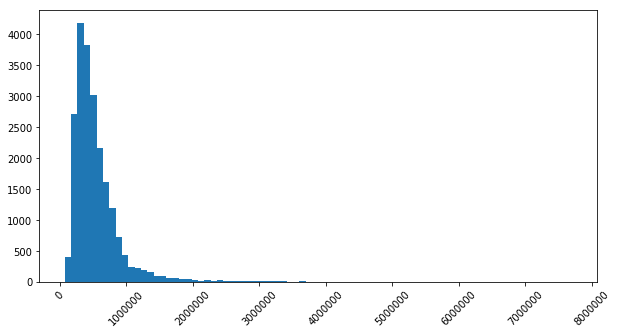

In [16]:
df['price'].hist(xlabelsize=10, xrot=45, bins=80, grid=False, figsize=(10,5));

### - Distribution across all variables

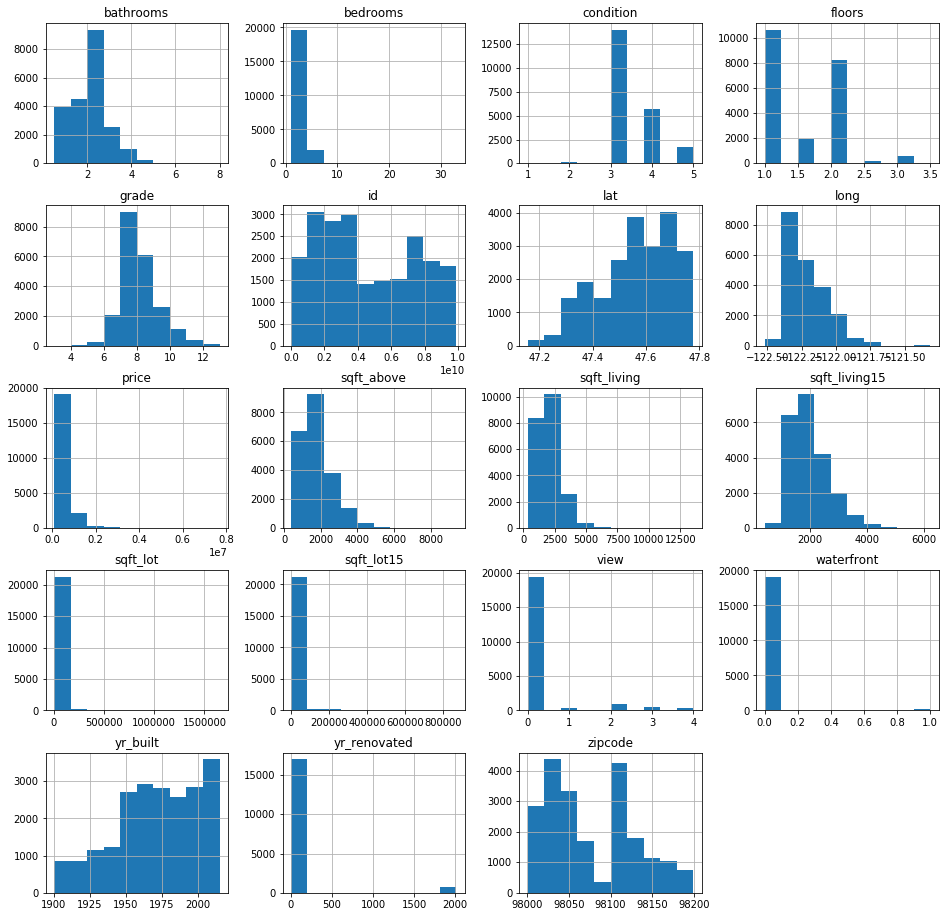

In [17]:
fig = plt.figure(figsize = (16,16))
ax = fig.gca()
df.hist(ax = ax);

<a id="Cleaning"></a>
# Data Cleaning:

## Summary of Data Cleaning:
* Dropped houses in dataset that were over $1M
* Droppped an extreme 'bedrooms' value's row
* Dummy coded 'waterfront' into 3 variables
* 'yr_renovated' column as very little useful data

## Dropping Data

In [18]:
df_cleaned = df

### - Dropping Price Outliers

In [19]:
df_cleaned = df_cleaned[df_cleaned['price']<cut_off_price]

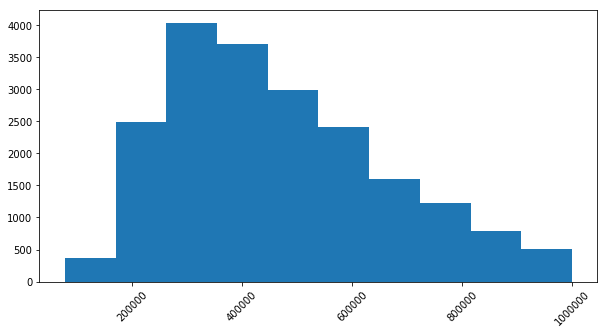

In [20]:
df_cleaned['price'].hist(xlabelsize=10, xrot=45, figsize=(10,5), grid=False, bins=10);

### - Dropping Extreme Bedrooms Value

In [21]:
df_cleaned = df_cleaned[df_cleaned['bedrooms']<33]

In [22]:
df_cleaned['bedrooms'].max()

11

<a id="cleaning_yr_renovated"></a>
### - Dropping 'yr_renovated' due to lack of useful data:

In [23]:
df_cleaned['yr_renovated'].value_counts().head()

0.0       15938
2014.0       63
2013.0       27
2000.0       25
2007.0       23
Name: yr_renovated, dtype: int64

In [24]:
df_cleaned['yr_renovated'].isna().sum()

3570


###### We can see from this that almost 96% of values in this column are '0'.  This column therefore doesn't offer much value
###### This is in addition to the NA values shown before
###### We can assume its bad data as when we look at duplicates and "quick rennovation" idea, the yr_renovated column is often == 0


<a id="Dummy-Coding"></a>
## Dummy-Coding Categorical Variables:

### - Waterfront

In [25]:
df_cleaned['waterfront'].value_counts()

0.0    17830
1.0       49
Name: waterfront, dtype: int64

In [26]:
# replaced the NaN values in 'waterfront' with the value 2.
df_cleaned['waterfront'] = df_cleaned['waterfront'].replace(np.nan,2)

In [27]:
#df_cleaned up to date til this stage
df_cleaned.shape

(20106, 21)

## Dealing with NaN values

<a id="cleaning_sqft_basement"></a>
### Replacing Nan and Extraneous Values in 'sqft_basement':

In [28]:
df_cleaned['sqft_basement_calc'] = df_cleaned['sqft_living']-df_cleaned['sqft_above']
df_cleaned[['sqft_basement', 'sqft_basement_calc']]

,sqft_basement,sqft_basement_calc
0,0.0,0
1,400.0,400
2,0.0,0
3,910.0,910
4,0.0,0
6,?,0
7,0.0,0
8,730.0,730
9,0.0,0
10,1700.0,1700


# !!!!!!!!!!!!!!!!This section can be taken out as we have quickly worked out the columns below!!!!!!!!!!

In [29]:
# df_cleaned['sqft_basement'].sort_values(ascending=False).head(2)

In [30]:
#creating a new temporary dataframe of sqft_basement, that doesn't include nan or '?'
# df_sqft_no_nan = df_cleaned[(~df_cleaned['sqft_basement'].isna()) & (df_cleaned['sqft_basement'] != '?')]

In [31]:
# How many nan and '?' values have we dropped? 
# len(df) - len(df_sqft_no_nan)

In [32]:
#can see that nan values in sqft_basement have been dropped from this dataframe
# e.g. row/index 6
# df_sqft_no_nan['sqft_basement'].head(8)

In [33]:
#convert whole column to int64 format
# df_sqft_no_nan['sqft_basement'] = df_sqft_no_nan['sqft_basement'].astype(float)

# df_sqft_no_nan['sqft_basement'].dtype
#shows that the df_sqft_no_nan is dtype int64

In [34]:
# sns.distplot(df_sqft_no_nan['sqft_basement']);
#the vast majority have a value of 0, otherwise the data looks normally distributed

In [35]:
# df_sqft_no_nan['sqft_basement'].value_counts(normalize=True).head(3)
# can see that 61% of sqft_basement is 0

In [36]:
# df_sqft_no_nan['sqft_basement'].describe().T
# median = 0, mean = 291.9

In [37]:
# df_cleaned.shape

In [38]:
# sqft_basement_median = float(np.median(df_sqft_no_nan['sqft_basement']))

# df_cleaned = df_cleaned.fillna(sqft_basement_median)
# df_cleaned = df_cleaned.replace('?',sqft_basement_median)

<a id="Converting-Datatypes"></a>
## Converting Datatypes:

# !!!!!! Don't NEED THIS CONVERSION TO FLOAT AS WE HAVE A NEW COLUMN!!!!!

### Converting 'sqft_basement' to float format:

In [39]:
# df_cleaned['sqft_basement'] = df_cleaned ['sqft_basement'].astype(float)
# type(df_cleaned['sqft_basement'][1])

<a id="datetime"></a>
### Converting 'date' to datetime format:

In [40]:
#converted the 'date' column from object to datetime format
pd.to_datetime(df_cleaned['date'], format="%m/%d/%Y").head(3)


0   2014-10-13
1   2014-12-09
2   2015-02-25
Name: date, dtype: datetime64[ns]

# Further Data Exploration

<a id="exploration-summary"></a>
## Summary of Further Data Exploration:

* 

Controllable: factors which homeowners conceivably have the opportunity to improve upon
* Size: sqft_basement, sqft_above, sqft_living, sqft_lot
* Amenities: bathrooms, bedrooms, floors
* Upkeep: grade, condition, yr_renovated

## Data Distribution

In [41]:
# df_cleaned['sqft_lot_yes'] = df_cleaned[df_cleaned['sqft_lot'>0]]

In [42]:
df_cleaned[df_cleaned['sqft_lot']<100000].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement_calc
count,1.969600e+04,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000,19641.000000,19696.000000,19696.000000,19696.000000,19696.000000,16177.000000,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000
mean,4.661518e+09,464985.432474,3.320370,2.033027,1941.660337,10025.532037,1.470146,0.224056,0.155949,3.406478,7.493400,1679.021527,1970.570979,71.297707,98079.314734,47.557511,-122.216850,1899.407545,9781.611799,262.638810
std,2.875517e+09,195158.187946,0.883244,0.700669,745.546622,11137.117209,0.537308,0.628923,0.606706,0.645556,1.004158,701.816821,29.188511,370.414967,53.491177,0.140689,0.139689,598.295457,13616.717058,401.894436
min,1.000102e+06,78000.000000,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.512000,399.000000,651.000000,0.000000
25%,2.206500e+09,311000.000000,3.000000,1.500000,1390.000000,5000.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1160.000000,1951.000000,0.000000,98033.000000,47.461900,-122.331000,1460.000000,5000.000000,0.000000
50%,4.022900e+09,430000.000000,3.000000,2.000000,1830.000000,7416.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1500.000000,1974.000000,0.000000,98070.000000,47.566900,-122.239000,1780.000000,7500.000000,0.000000
75%,7.421175e+09,589999.250000,4.000000,2.500000,2390.000000,10013.250000,2.000000,0.000000,0.000000,4.000000,8.000000,2060.000000,1996.000000,0.000000,98118.000000,47.680525,-122.128000,2240.000000,9680.000000,500.000000
max,9.900000e+09,999999.000000,11.000000,7.500000,7480.000000,99916.000000,3.500000,2.000000,4.000000,5.000000,12.000000,5710.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,4950.000000,392040.000000,2400.000000


In [43]:
df_cleaned[df_cleaned['sqft_lot']>1000].info()
# df[df['price']>cut_off_price]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19903 entries, 0 to 21596
Data columns (total 22 columns):
id                    19903 non-null int64
date                  19903 non-null object
price                 19903 non-null float64
bedrooms              19903 non-null int64
bathrooms             19903 non-null float64
sqft_living           19903 non-null int64
sqft_lot              19903 non-null int64
floors                19903 non-null float64
waterfront            19903 non-null float64
view                  19846 non-null float64
condition             19903 non-null int64
grade                 19903 non-null int64
sqft_above            19903 non-null int64
sqft_basement         19903 non-null object
yr_built              19903 non-null int64
yr_renovated          16371 non-null float64
zipcode               19903 non-null int64
lat                   19903 non-null float64
long                  19903 non-null float64
sqft_living15         19903 non-null int64
sqft_lot15   

In [44]:
#DFs for plotting different controllable groups
df_size = df_cleaned[['sqft_above', 'sqft_lot', 'sqft_living', 'sqft_basement']]
df_amenities = df_cleaned[['bathrooms', 'bedrooms', 'floors']]
df_upkeep = df_cleaned[['grade', 'condition', 'yr_renovated']]

### - Histograms for Size variables

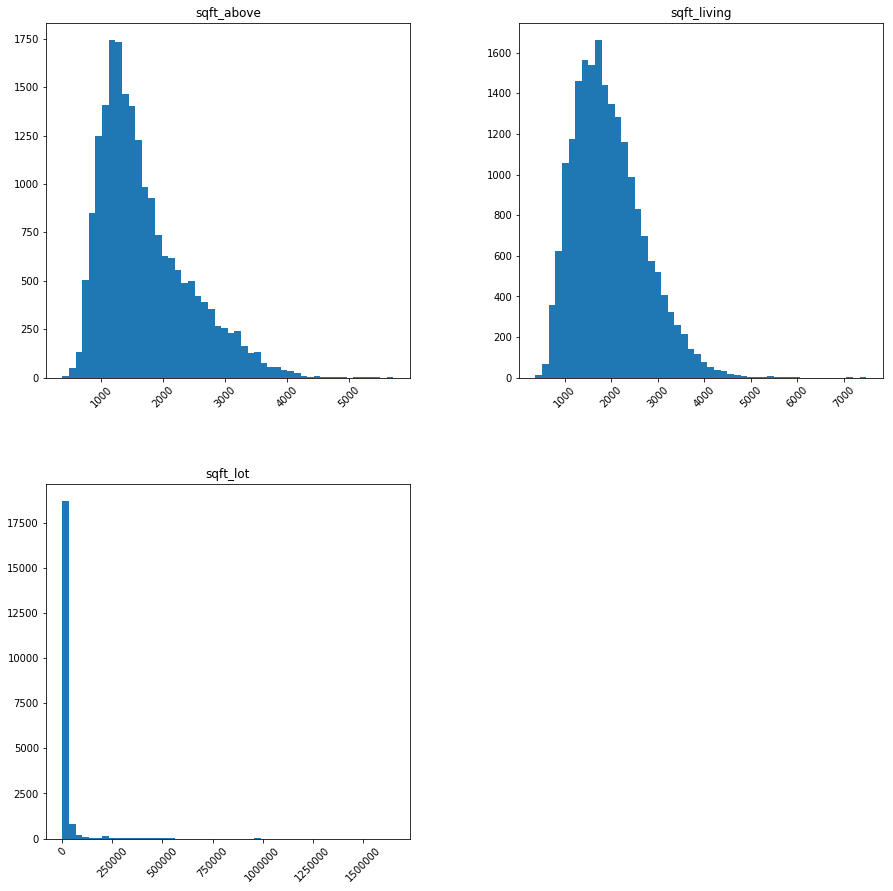

In [45]:
df_size.hist(xlabelsize=10, xrot=45, figsize=(15,15), grid=False, bins=50);

### - Histograms for Amenities variables

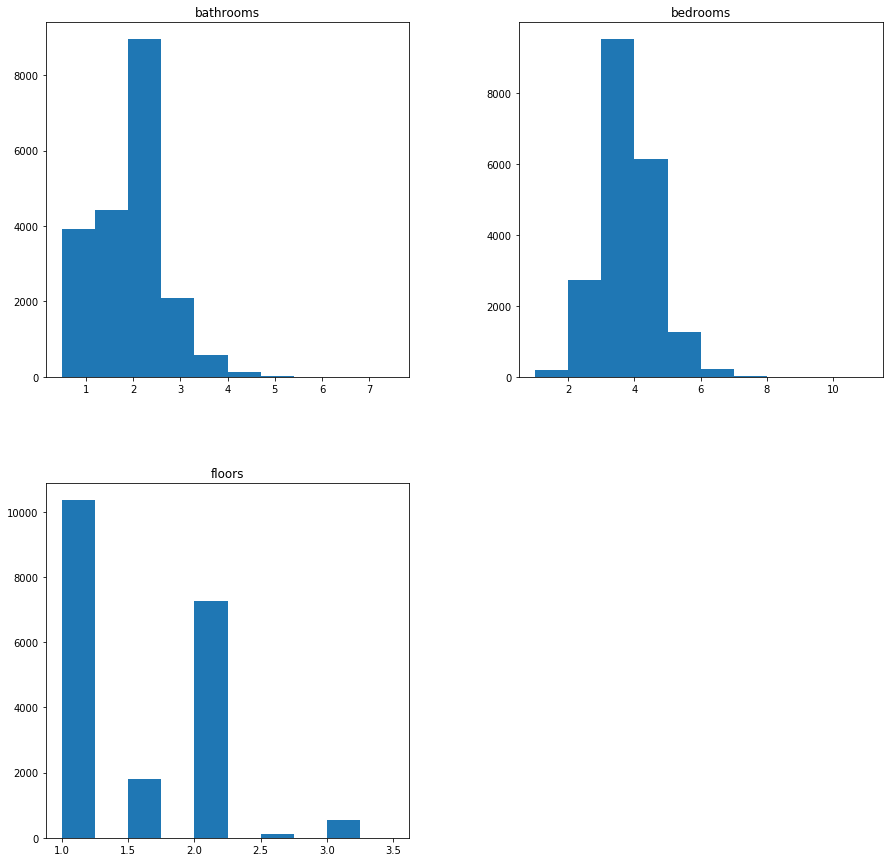

In [46]:
df_amenities.hist(xlabelsize=10, figsize=(15,15), grid=False);

### - Histograms for Upkeep variables

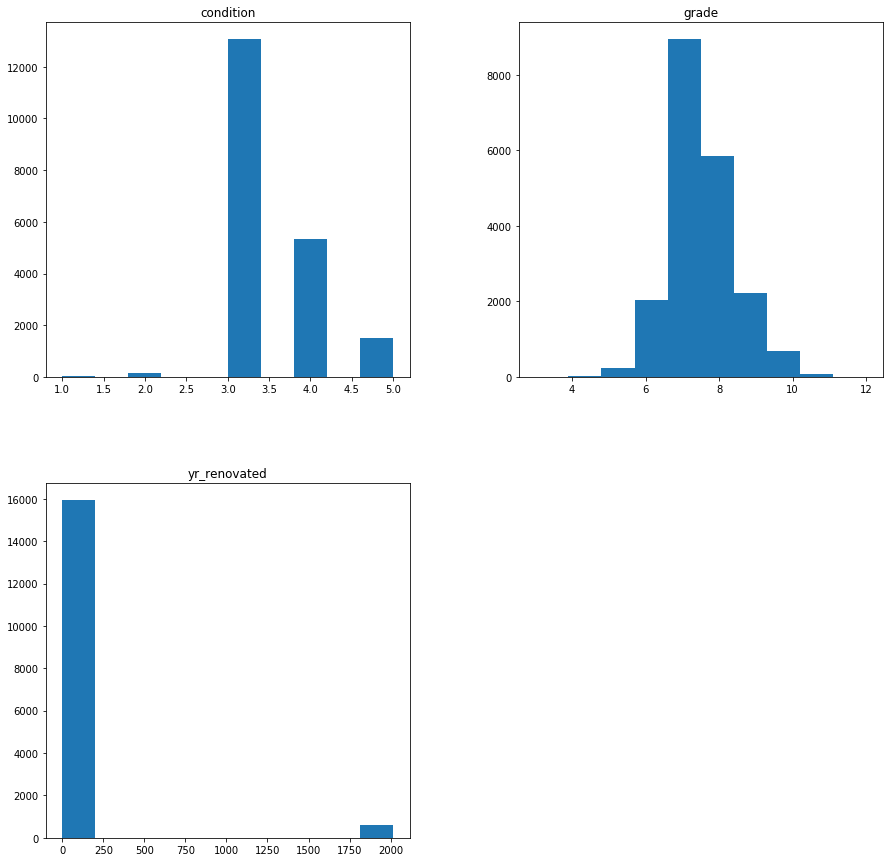

In [47]:
df_upkeep.hist(xlabelsize=10, figsize=(15,15), grid=False);

# Modeling Decisions:

## Checking For Normal Distributions:

## Checking Linear Relationship Assumption:

https://seaborn.pydata.org/tutorial/regression.html#functions-to-draw-linear-regression-models

In [64]:
df_cleaned['has_basement'] = df_cleaned['sqft_basement_calc']>0
df_cleaned['has_basement']

0        False
1         True
2        False
3         True
4        False
6        False
7        False
8         True
9        False
10        True
11        True
12       False
13       False
14       False
15        True
16       False
17       False
18       False
19       False
20        True
22       False
23       False
24       False
25       False
26        True
27       False
28        True
29       False
30       False
31       False
         ...  
21562    False
21563     True
21564    False
21565    False
21566     True
21567    False
21568     True
21569    False
21570    False
21571    False
21572     True
21573    False
21575    False
21576    False
21578    False
21579     True
21580    False
21582    False
21583    False
21585    False
21586    False
21587    False
21588    False
21589    False
21591     True
21592    False
21593    False
21594    False
21595    False
21596    False
Name: has_basement, Length: 20106, dtype: bool

In [60]:
# df_has_basement = df_cleaned[df_cleaned['sqft_basement_calc']>0]
# df_has_basement

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement_calc
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,400
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,910
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113,730
10,1736800520,4/3/2015,662500.0,3,2.50,3560,9796,1.0,2.0,0.0,...,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925,1700
11,9212900260,5/27/2014,468000.0,2,1.00,1160,6000,1.0,0.0,0.0,...,860,300.0,1942,0.0,98115,47.6900,-122.292,1330,6000,300
15,9297300055,1/24/2015,650000.0,4,3.00,2950,5000,2.0,0.0,3.0,...,1980,970.0,1979,0.0,98126,47.5714,-122.375,2140,4000,970
20,6300500875,5/14/2014,385000.0,4,1.75,1620,4980,1.0,0.0,0.0,...,860,760.0,1947,0.0,98133,47.7025,-122.341,1400,4980,760
26,1794500383,6/26/2014,937000.0,3,1.75,2450,2691,2.0,0.0,0.0,...,1750,700.0,1915,NaN,98119,47.6386,-122.360,1760,3573,700
28,5101402488,6/24/2014,438000.0,3,1.75,1520,6380,1.0,0.0,0.0,...,790,730.0,1948,NaN,98115,47.6950,-122.304,1520,6235,730
32,461000390,6/24/2014,687500.0,4,1.75,2330,5000,1.5,0.0,0.0,...,1510,820.0,1929,0.0,98117,47.6823,-122.368,1460,5000,820


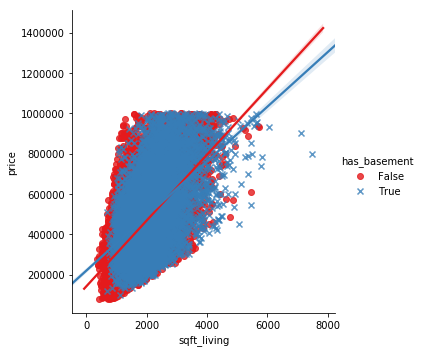

In [84]:
#Shows the sqft_living variation in price.  split into whether has basement or not
sns.lmplot(x="sqft_living", y="price", hue='has_basement', data=df_cleaned, markers=["o", "x"], palette="Set1");

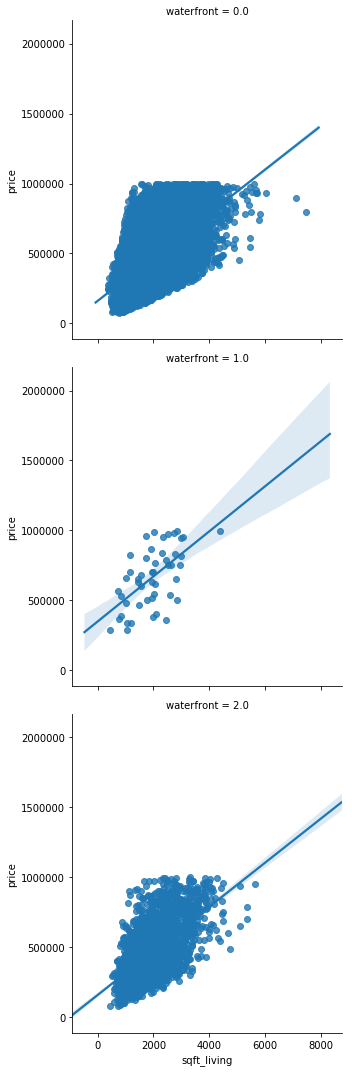

In [90]:
sns.lmplot(x="sqft_living", y="price", row='waterfront', data=df_cleaned, palette="Set1");

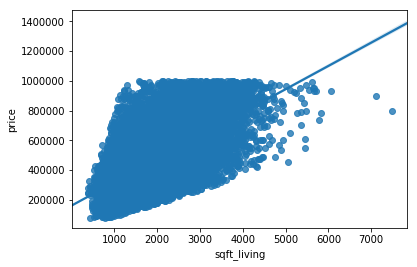

In [52]:
sns.regplot(x="sqft_living", y="price", data=df_cleaned);

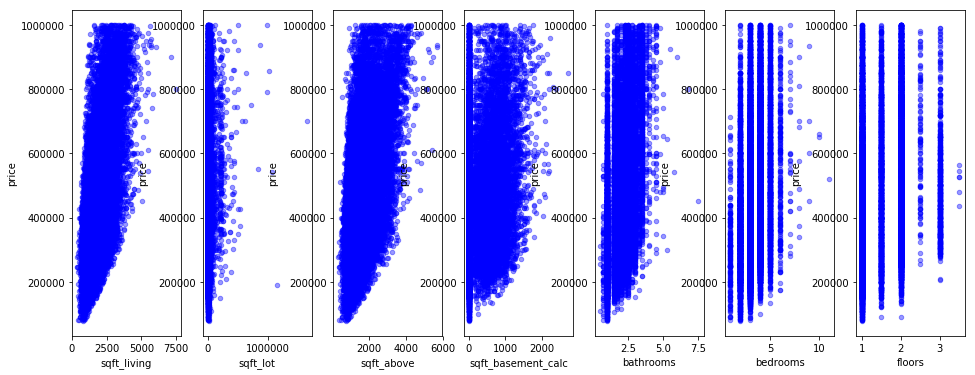

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16,6))

for xcol, ax in zip(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement_calc', 'bathrooms', 'bedrooms','floors'], axes):
    df_cleaned.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

In [49]:
#see previous comments in categorizing zipcode; decision to use sq_ft_!5 instead
#scatter to see if there's extremes of zipcode vs price
#get the mean price of each property in each zipcode category and plot mean price vs zipcode


## Correlation Matrices:

### Investigating Top Predictors of Price:

In [50]:
#df_cleaned.corr()[['price']].sort_values(by=['price'], ascending=False)
    

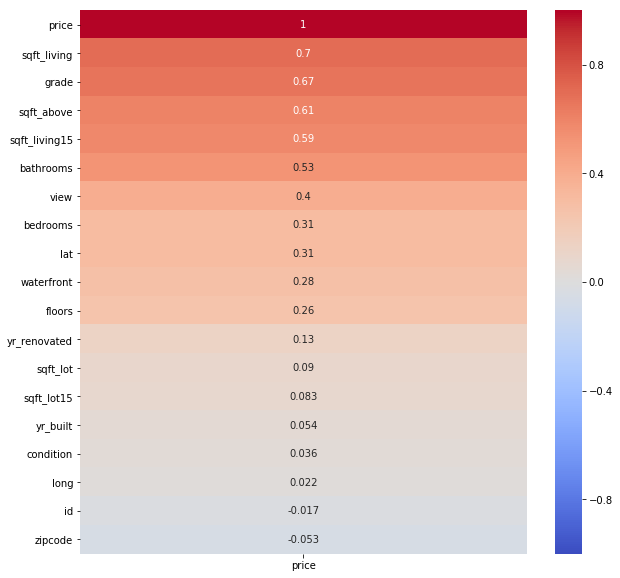

In [51]:
#Plot a heatmap to see where which variables are strongly correlated with target "price"
plt.figure(figsize = (10, 10))
sns.heatmap(df.corr()[['price']].sort_values(by=['price'],ascending=False), vmin = -1, vmax = 1, cmap = 'coolwarm', annot=True)
#from the heatmap below we can see that there are no strong negative correlations, but there are several positive correlations:
#bathrooms, sqft_living, grade, sqft_above, sqft_living15

## Investigating Multicollinearity:

In [52]:
#no correlations above .90 - can assume independence of IVs
#df_cleaned.corr().round(2)


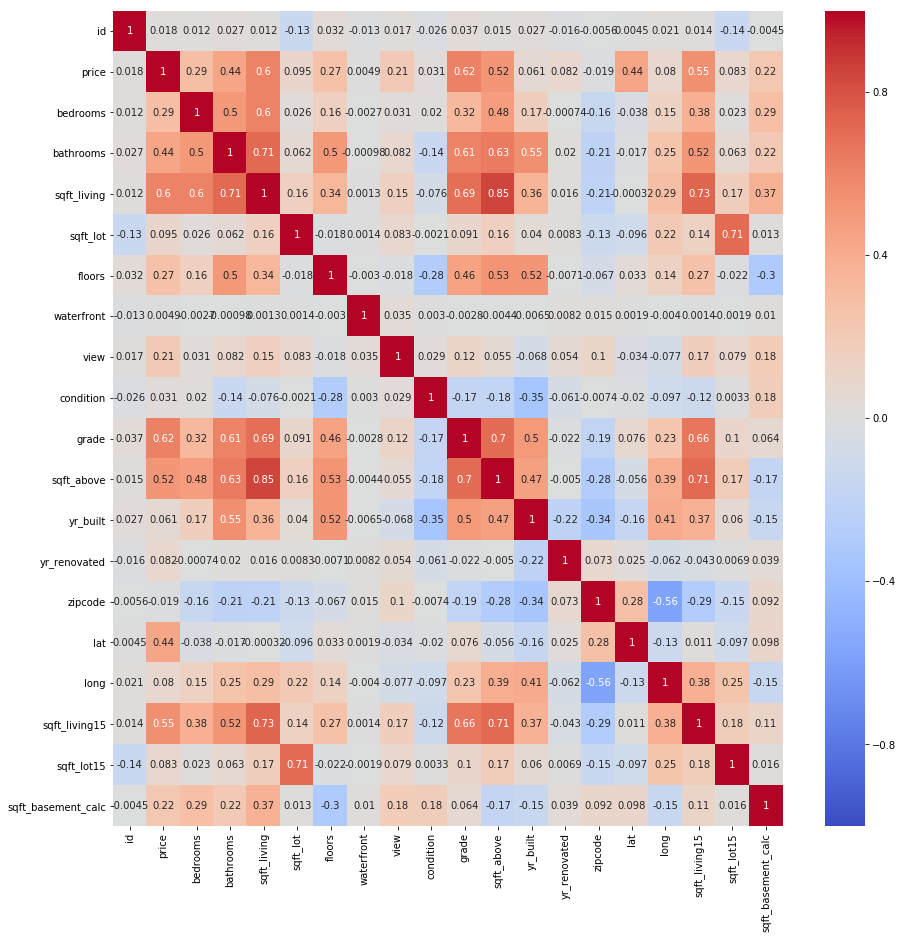

In [53]:
# come back and add a filter for correlation table so zip codes are not displayed
#checking for correlations of .90 or above between IVs 
plt.figure(figsize = (15, 15))
sns.heatmap(df_cleaned.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True);



# Building a MLR Model:  

### "How Can Homeowners Improve The Selling Price of their Home?"

####  In order to answer this question, we first categorized the variables in our dataset into two categories: 

#### Uncontrollable: factors which are beyond the homeowners' control
- Geographic: latitude, longitude, zipcode, sqft_living15, waterfront

#### Controllable: factors which homeowners conceivably have the opportunity to improve upon
- Size: sqft_basement, sqft_above, sqft_living, sqft_lot
- Amenities: bathrooms, bedrooms, floors
- Upkeep: grade, condition, yr_renovated

#### Based on examining correlation coefficients and our understanding of the variables' relationships to one another we decided to do use a stepwise approach to building an optimal regression model.

In [54]:
#displaying full list of variables
df_cleaned.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_basement_calc'],
      dtype='object')

## Baseline Model 

In [55]:
#calculating baseline model R^2 = 0.0
import sklearn as sk
df_cleaned['price_pred'] = df_cleaned['price'].mean()
sk.metrics.r2_score(df_cleaned['price'],df_cleaned['price_pred'])

0.0

## Model 0: Baseline Model

In [56]:
X0 = df_cleaned[['price_pred']]
y = df_cleaned[['price']]

model0 = sm.OLS(y, X0).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 08 May 2019   Prob (F-statistic):                nan
Time:                        20:00:23   Log-Likelihood:            -2.7349e+05
No. Observations:               20106   AIC:                         5.470e+05
Df Residuals:                   20105   BIC:                         5.470e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price_pred     1.0000      0.003    338.795      0.000       0.994       1.006
==============================================================================
Omnibus:                     1229.501   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1377.773
Skew:                           0.619   Prob(JB):                    6.61e-300
Kurtosis:                       2.668   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 1: sqft_living

In [57]:
# setting our dependent and independent variables for Model 1
X1 = df_cleaned[['sqft_living']]
y = df_cleaned[['price']]

# Displaying summary of Model 1 OLS
model1 = sm.OLS(y, X1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 1.665e+05
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -2.7023e+05
No. Observations:               20106   AIC:                         5.405e+05
Df Residuals:                   20105   BIC:                         5.405e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   228.3024      0.560    407.986      0.000     227.206     229.399
==============================================================================
Omnibus:                      149.549   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.390
Skew:                           0.170   Prob(JB):                     7.40e-37
Kurtosis:                       3.287   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
# OLD CODE (DIDNT HAVE LABELS OF PREDICTORS)
# predictors = np.asarray(X)  #setting what the predictors are 
# predictors_int = sm.add_constant(predictors) #
# model_1 = sm.OLS(y, predictors_int).fit()    
# model_1.summary()

## Model 2:  sqft_living, grade

In [59]:
X2 = df_cleaned[['sqft_living','grade']]
y = df_cleaned[['price']]

model2 = sm.OLS(y, X2).fit()
model2.summary()

# X2 = df_cleaned[['sqft_living','grade']]
# y = df_cleaned[['price']]

# predictors = np.asarray(X)  
# predictors_int = sm.add_constant(predictors) 

# model = sm.OLS(y, predictors_int).fit()    
# model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 1.053e+05
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -2.6809e+05
No. Observations:               20106   AIC:                         5.362e+05
Df Residuals:                   20104   BIC:                         5.362e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   112.5398      1.752     64.243      0.000     109.106     115.973
grade        3.344e+04    484.738     68.990      0.000    3.25e+04    3.44e+04
==============================================================================
Omnibus:                      864.729   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              981.136
Skew:                           0.541   Prob(JB):                    8.89e-214
Kurtosis:                       2.974   Cond. No.                         963.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 3: sqft_living, grade, bathrooms

In [60]:
X3 = df_cleaned[['sqft_living', 'grade','bathrooms']]
y = df_cleaned[['price']]

model3 = sm.OLS(y, X3).fit()
model3.summary()
#coef of bathrooms is -ve!!

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 7.046e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -2.6806e+05
No. Observations:               20106   AIC:                         5.361e+05
Df Residuals:                   20103   BIC:                         5.361e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   122.0752      2.101     58.091      0.000     117.956     126.194
grade        3.583e+04    564.968     63.416      0.000    3.47e+04    3.69e+04
bathrooms   -1.791e+04   2188.230     -8.184      0.000   -2.22e+04   -1.36e+04
==============================================================================
Omnibus:                      838.766   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              948.112
Skew:                           0.532   Prob(JB):                    1.32e-206
Kurtosis:                       2.976   Cond. No.                     4.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
# NUMBERS SEEM VERY OFF. ALSO NUMBERS DONT AGREE WITH ABOVE, BUT SHOULDNT THEY BE THE SAME?

X3 = df_cleaned[['sqft_living', 'grade','bathrooms']]
y = df_cleaned[['price']]

predictors = np.asarray(X3)  #setting what the predictors are 
predictors_int = sm.add_constant(predictors) #
model = sm.OLS(y, predictors_int).fit()    
model.summary() #look at OLS stats documentation to see if we can pull out coefficients

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     5333.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -2.6760e+05
No. Observations:               20106   AIC:                         5.352e+05
Df Residuals:                   20102   BIC:                         5.352e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.605e+05   8527.214    -30.547      0.000   -2.77e+05   -2.44e+05
x1            98.2908      2.197     44.740      0.000      93.985     102.597
x2          7.673e+04   1448.419     52.975      0.000    7.39e+04    7.96e+04
x3         -1.974e+04   2140.039     -9.225      0.000   -2.39e+04   -1.55e+04
==============================================================================
Omnibus:                      804.882   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              903.630
Skew:                           0.511   Prob(JB):                    6.01e-197
Kurtosis:                       3.189   Cond. No.                     1.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Because the relationship between bathrooms and price was found to be negative (which doesn't make logical sense), we decided to drop bathrooms from the model and add another feature (bedrooms) into the model 4 below

## Model 4:  sqft_living, grade, bedrooms

In [62]:
X4 = df_cleaned[['sqft_living','grade','bedrooms']]
y = df_cleaned[['price']]

model4 = sm.OLS(y, X4).fit()
model4.summary()

#!Bedrooms coef very -ve

# predictors = np.asarray(X)  #setting what the predictors are 
# predictors_int = sm.add_constant(predictors) #
# model = sm.OLS(y, predictors_int).fit()    
# model.summary() #look at OLS stats documentation to see if we can pull out coefficients

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 7.184e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -2.6788e+05
No. Observations:               20106   AIC:                         5.358e+05
Df Residuals:                   20103   BIC:                         5.358e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   128.8584      1.904     67.691      0.000     125.127     132.590
grade         4.14e+04    614.324     67.395      0.000    4.02e+04    4.26e+04
bedrooms    -2.794e+04   1347.483    -20.738      0.000   -3.06e+04   -2.53e+04
==============================================================================
Omnibus:                      918.480   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1048.603
Skew:                           0.557   Prob(JB):                    1.99e-228
Kurtosis:                       3.107   Cond. No.                     2.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Because the relationship between bedrooms and price was found to be negative (which doesn't make logical sense), we decided to drop bedrooms from the model and add another feature (floors) into the model 5 below

## Model 5:  sqft_living, grade, floors

In [63]:
X5 = df_cleaned[['sqft_living','grade','floors']]
y = df_cleaned[['price']]

model5 = sm.OLS(y, X5).fit()
model5.summary()

#!Floors coef -ve

# predictors = np.asarray(X)  #setting what the predictors are 
# predictors_int = sm.add_constant(predictors) #
# model = sm.OLS(y, predictors_int).fit()    
# model.summary() #look at OLS stats documentation to see if we can pull out coefficients

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 7.021e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -2.6809e+05
No. Observations:               20106   AIC:                         5.362e+05
Df Residuals:                   20103   BIC:                         5.362e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   112.7593      1.756     64.220      0.000     109.318     116.201
grade        3.418e+04    629.890     54.256      0.000    3.29e+04    3.54e+04
floors      -4021.4491   2205.542     -1.823      0.068   -8344.493     301.595
==============================================================================
Omnibus:                      858.860   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              973.626
Skew:                           0.539   Prob(JB):                    3.80e-212
Kurtosis:                       2.973   Cond. No.                     4.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model 6: note: explored with diff. variable iterations, none of which worked. Not including in chart.

In [64]:
X6 = df_cleaned[['sqft_living','grade','sqft_lot']]
y = df_cleaned[['price']]

model6 = sm.OLS(y, X6).fit()
model6.summary()

#sqft_lot seems to have no impact.  (very small coefficient)

# predictors = np.asarray(X)  #setting what the predictors are 
# predictors_int = sm.add_constant(predictors) #
# model = sm.OLS(y, predictors_int).fit()    
# model.summary() #look at OLS stats documentation to see if we can pull out coefficients

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 7.020e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -2.6809e+05
No. Observations:               20106   AIC:                         5.362e+05
Df Residuals:                   20103   BIC:                         5.362e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   112.3667      1.768     63.540      0.000     108.900     115.833
grade        3.345e+04    484.885     68.986      0.000    3.25e+04    3.44e+04
sqft_lot        0.0191      0.027      0.716      0.474      -0.033       0.071
==============================================================================
Omnibus:                      867.366   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              984.508
Skew:                           0.542   Prob(JB):                    1.65e-214
Kurtosis:                       2.975   Cond. No.                     1.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model 7:  sqft_living, grade, floors, bathrooms, bedrooms, sqft_lot

In [65]:
X7 = df_cleaned[['sqft_living','grade', 'floors', 'bathrooms', 'bedrooms', 'sqft_lot']]
y = df_cleaned[['price']]

model7 = sm.OLS(y, X7).fit()
model7.summary()

#highest R^2 BUT
# p value of bathrooms is too high?
# coef of bathrooms is MASSIVELY -ve
# coef of sqft_lot still very low

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 3.598e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -2.6786e+05
No. Observations:               20106   AIC:                         5.357e+05
Df Residuals:                   20100   BIC:                         5.358e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   134.7356      2.216     60.807      0.000     130.392     139.079
grade          4.3e+04    747.540     57.521      0.000    4.15e+04    4.45e+04
floors      -1941.7824   2346.703     -0.827      0.408   -6541.513    2657.948
bathrooms   -1.119e+04   2351.276     -4.759      0.000   -1.58e+04   -6580.322
bedrooms    -2.713e+04   1370.389    -19.794      0.000   -2.98e+04   -2.44e+04
sqft_lot       -0.0323      0.027     -1.214      0.225      -0.084       0.020
==============================================================================
Omnibus:                      892.255   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1014.847
Skew:                           0.548   Prob(JB):                    4.25e-221
Kurtosis:                       3.105   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model 8:  sqft_living, grade, bathrooms, 

In [66]:
X8 = df_cleaned[['sqft_living','grade', 'bathrooms']]
y = df_cleaned[['price']]

model8 = sm.OLS(y, X8).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 7.046e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -2.6806e+05
No. Observations:               20106   AIC:                         5.361e+05
Df Residuals:                   20103   BIC:                         5.361e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   122.0752      2.101     58.091      0.000     117.956     126.194
grade        3.583e+04    564.968     63.416      0.000    3.47e+04    3.69e+04
bathrooms   -1.791e+04   2188.230     -8.184      0.000   -2.22e+04   -1.36e+04
==============================================================================
Omnibus:                      838.766   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              948.112
Skew:                           0.532   Prob(JB):                    1.32e-206
Kurtosis:                       2.976   Cond. No.                     4.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model 9:  sqft_above, sqft_ basement, grade, floors, bathrooms, bedrooms

In [67]:
X9 = df_cleaned[['sqft_above', 'sqft_basement', 'grade', 'floors', 'bathrooms', 'bedrooms']]
y = df_cleaned[['price']]

model9 = sm.OLS(y, X9).fit()
model9.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

## Training and Testing Our Model Using K-Fold Cross-Validation:

### Decided to test Model 2 with sqft_living and grade, based on R^2 and coefficents

In [68]:
X = df_cleaned[['sqft_living','grade']]
y = df_cleaned[['price']]

predictors = np.asarray(X)  
predictors_int = sm.add_constant(predictors) 
model = sm.OLS(y, predictors_int).fit()    
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     7924.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        20:03:47   Log-Likelihood:            -2.6764e+05
No. Observations:               20106   AIC:                         5.353e+05
Df Residuals:                   20103   BIC:                         5.353e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.583e+05   8541.674    -30.237      0.000   -2.75e+05   -2.42e+05
x1            87.9891      1.896     46.409      0.000      84.273      91.705
x2          7.376e+04   1415.027     52.123      0.000     7.1e+04    7.65e+04
==============================================================================
Omnibus:                      830.421   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              935.539
Skew:                           0.521   Prob(JB):                    7.08e-204
Kurtosis:                       3.178   Cond. No.                     1.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
#setting up the train/test splits for cross-validating our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [70]:
#preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

16084 4022 16084 4022


In [71]:
#Fit the model and apply the model to the make test set predictions 
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [72]:
#Calculate the residuals and the mean squared error
from sklearn.metrics import mean_squared_error
test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)**0.5
test_mse  
#test_mse results indicate our residuals are, on average, a distance of
#$240,450 from the fitted line


145807.37656449334

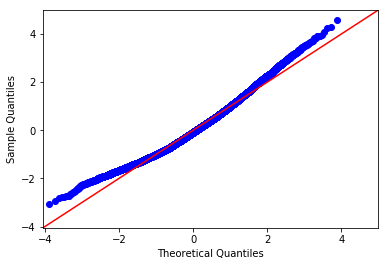

In [73]:
#Residual Plot:
#qq plots show 
residuals = model.resid
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

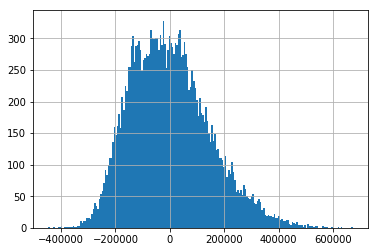

In [74]:
residuals.hist(bins=200)


# Summary of Findings